In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

BASE = os.path.expanduser("~/Desktop/bonds_project")
DATA = os.path.join(BASE, "data")
FIGS = os.path.join(BASE, "figs")
os.makedirs(FIGS, exist_ok=True)

BT_PATH  = os.path.join(DATA, "backtest.csv")            # from Step 5
SIM_PATH = os.path.join(DATA, "sim_results.parquet")     # from Step 6

bt  = pd.read_csv(BT_PATH, parse_dates=["date"]).set_index("date")
sim = pd.read_parquet(SIM_PATH)

print("Backtest rows:", len(bt), "| Sim rows:", len(sim))
bt.tail(), sim.head()



Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Backtest rows: 2035 | Sim rows: 252000


(                P_port    IEF    TLT     h_IEF     h_TLT  dPnL_port  \
 date                                                                  
 2025-10-14  287.777137  97.21  90.86  2.176624 -0.199750   0.480071   
 2025-10-15  287.440768  97.10  90.66  2.176624 -0.199750  -0.336369   
 2025-10-16  288.471060  97.55  91.34  2.176624 -0.199750   1.030292   
 2025-10-17  287.943888  97.39  91.20  2.176624 -0.199750  -0.527172   
 2025-10-20  287.943888  97.52  91.54  2.190629 -0.202766   0.000000   
 
             dPnL_hedge  dPnL_combo  
 date                                
 2025-10-14   -0.486229   -0.006157  
 2025-10-15    0.199479   -0.136891  
 2025-10-16   -0.843651    0.186641  
 2025-10-17    0.320295   -0.206877  
 2025-10-20   -0.215841   -0.215841  ,
    path  t  dPnL_port  dPnL_hedge  dPnL_combo     model
 0     0  1  -0.805369    0.754485   -0.050884  parallel
 1     0  2   0.006886   -0.006437    0.000449  parallel
 2     0  3  -0.774968    0.725787   -0.049181  parallel

In [2]:
def ann_vol(x):
    x = pd.Series(x).dropna()
    return float(x.std() * np.sqrt(252))

def var_reduction(unhedged, hedged):
    u = pd.Series(unhedged).dropna()
    h = pd.Series(hedged).dropna()
    return float(100.0 * (1 - (h.var() / u.var())))

def tracking_error(hedged, unhedged):
    diff = pd.Series(hedged).dropna().align(pd.Series(unhedged).dropna(), join='inner')[0] - \
           pd.Series(unhedged).dropna().align(pd.Series(hedged).dropna(), join='inner')[0]
    return ann_vol(diff)

def max_drawdown(daily_pnl):
    cum = pd.Series(daily_pnl).cumsum()
    peak = cum.cummax()
    dd = cum - peak
    return float(dd.min())

def hist_var(x, p=0.95):
    x = pd.Series(x).dropna()
    # 1-day historical VaR at confidence p (negative = loss threshold)
    return float(np.quantile(x, 1 - p))

def sharpe_like(x):
    # Real Sharpe needs risk-free; this is a scale-free signal-to-noise
    x = pd.Series(x).dropna()
    mu = x.mean() * 252
    sd = x.std() * np.sqrt(252)
    return float(mu / sd) if sd > 0 else np.nan


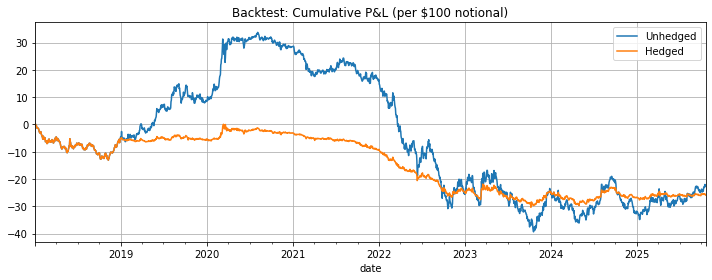

<Figure size 720x288 with 0 Axes>

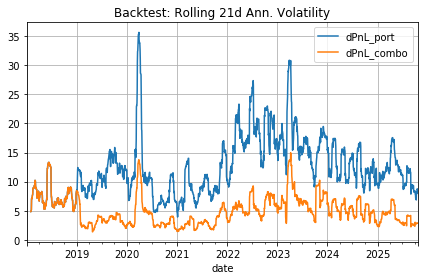

<Figure size 576x288 with 0 Axes>

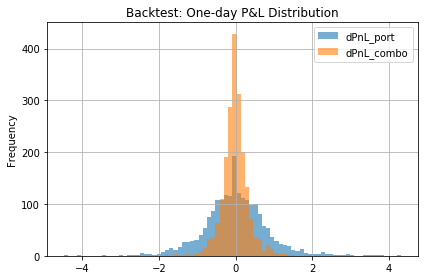

(                      Backtest_Overall
 AnnVol_unhedged                13.3088
 AnnVol_hedged                   5.5428
 VarianceReduction_%            82.6548
 TE_vol                          9.9860
 MaxDD_unhedged                -73.0640
 MaxDD_hedged                  -30.4559
 VaR95_unhedged                 -1.3505
 VaR95_hedged                   -0.5417
 VaR99_unhedged                 -2.2298
 VaR99_hedged                   -0.9118
 Sharpe_like_unhedged           -0.2095
 Sharpe_like_hedged             -0.5780,
       AnnVol_unhedged  AnnVol_hedged  VarianceReduction_%  MaxDD_unhedged  \
 Year                                                                        
 2018           7.8595         7.8359               0.5996        -13.2205   
 2019          11.1397         3.1828              91.8367         -7.1356   
 2020          13.0331         5.0486              84.9946         -8.5670   
 2021           9.8114         3.2936              88.7310        -13.6411   
 2022      

In [3]:
# Align series
pU = bt["dPnL_port"]
pH = bt["dPnL_combo"]

summary_bt = pd.Series({
    "AnnVol_unhedged": ann_vol(pU),
    "AnnVol_hedged": ann_vol(pH),
    "VarianceReduction_%": var_reduction(pU, pH),
    "TE_vol": tracking_error(pH, pU),
    "MaxDD_unhedged": max_drawdown(pU),
    "MaxDD_hedged": max_drawdown(pH),
    "VaR95_unhedged": hist_var(pU, 0.95),
    "VaR95_hedged": hist_var(pH, 0.95),
    "VaR99_unhedged": hist_var(pU, 0.99),
    "VaR99_hedged": hist_var(pH, 0.99),
    "Sharpe_like_unhedged": sharpe_like(pU),
    "Sharpe_like_hedged": sharpe_like(pH),
}).to_frame("Backtest_Overall")

# By calendar year
def yearly_table(df):
    rows = []
    for y, grp in df.groupby(df.index.year):
        u, h = grp["dPnL_port"], grp["dPnL_combo"]
        rows.append({
            "Year": y,
            "AnnVol_unhedged": ann_vol(u),
            "AnnVol_hedged": ann_vol(h),
            "VarianceReduction_%": var_reduction(u, h),
            "MaxDD_unhedged": max_drawdown(u),
            "MaxDD_hedged": max_drawdown(h),
            "VaR95_unhedged": hist_var(u, 0.95),
            "VaR95_hedged": hist_var(h, 0.95),
            "Sharpe_like_unhedged": sharpe_like(u),
            "Sharpe_like_hedged": sharpe_like(h),
        })
    return pd.DataFrame(rows).set_index("Year").sort_index()

summary_bt_yearly = yearly_table(bt)

# Save tables
summary_bt.round(4).to_csv(os.path.join(DATA, "backtest_summary_overall.csv"))
summary_bt_yearly.round(4).to_csv(os.path.join(DATA, "backtest_summary_by_year.csv"))

# Plots
plt.figure(figsize=(10,4))
(pU.cumsum()).plot(label="Unhedged")
(pH.cumsum()).plot(label="Hedged")
plt.title("Backtest: Cumulative P&L (per $100 notional)"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(FIGS, "bt_cum_pnl.png"), dpi=150); plt.show()

plt.figure(figsize=(10,4))
bt[["dPnL_port","dPnL_combo"]].rolling(21).std().mul(np.sqrt(252)).plot()
plt.title("Backtest: Rolling 21d Ann. Volatility"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(FIGS, "bt_rolling_vol.png"), dpi=150); plt.show()

plt.figure(figsize=(8,4))
bt[["dPnL_port","dPnL_combo"]].plot(kind="hist", bins=80, alpha=0.6)
plt.title("Backtest: One-day P&L Distribution"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(FIGS, "bt_pnl_hist.png"), dpi=150); plt.show()

summary_bt.round(4), summary_bt_yearly.round(4)


<Figure size 720x216 with 0 Axes>

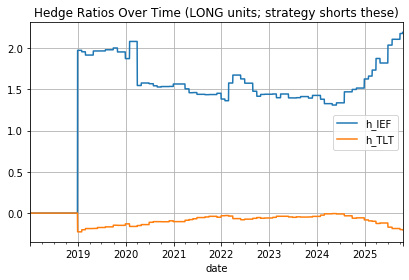

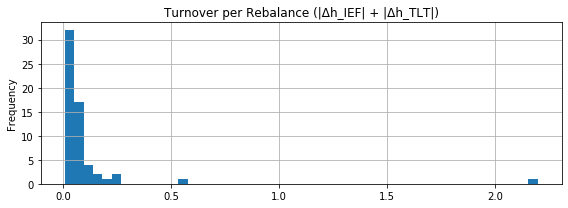

Mean_turnover       0.1029
Median_turnover     0.0463
Max_turnover        2.1999
Rebalance_count    60.0000
dtype: float64

In [4]:
# Hedge ratios are LONG units (we short them to hedge)
h = bt[["h_IEF","h_TLT"]].copy()
# Rebalance dates ~ where ratios jump
dh = h.diff().abs()
turnover = dh.sum(axis=1)  # simple proxy

plt.figure(figsize=(10,3))
h.plot()
plt.title("Hedge Ratios Over Time (LONG units; strategy shorts these)"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(FIGS, "bt_hedge_ratios.png"), dpi=150); plt.show()

plt.figure(figsize=(8,3))
turnover[turnover>0].plot(kind="hist", bins=50)
plt.title("Turnover per Rebalance (|Δh_IEF| + |Δh_TLT|)"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(FIGS, "bt_turnover_hist.png"), dpi=150); plt.show()

turnover_summary = pd.Series({
    "Mean_turnover": float(turnover[turnover>0].mean()),
    "Median_turnover": float(turnover[turnover>0].median()),
    "Max_turnover": float(turnover.max()),
    "Rebalance_count": int((turnover>0).sum())
})
turnover_summary.round(4)


Parallel model percentiles:
      AnnVol_unhedged  AnnVol_hedged  VarReduction_%  VaR95_unhedged  \
P25           13.389          0.804          99.577          -1.508   
P50           13.842          0.850          99.619          -1.427   
P75           14.398          0.897          99.666          -1.356   

     VaR95_hedged  MaxDD_unhedged  MaxDD_hedged  
P25        -0.089         -18.993        -0.968  
P50        -0.082         -14.766        -0.746  
P75        -0.076         -11.490        -0.575  

Level+Slope model percentiles:
      AnnVol_unhedged  AnnVol_hedged  VarReduction_%  VaR95_unhedged  \
P25           13.727          1.020          99.377          -1.533   
P50           14.282          1.062          99.441          -1.461   
P75           14.827          1.108          99.507          -1.403   

     VaR95_hedged  MaxDD_unhedged  MaxDD_hedged  
P25        -0.113         -20.643        -1.374  
P50        -0.106         -16.517        -1.034  
P75        -0.100 

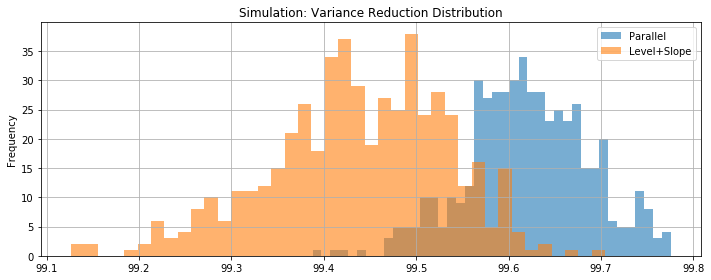

In [5]:
def summarize_mc(df):
    g = df.groupby("path")
    dU = g["dPnL_port"].sum()
    dH = g["dPnL_combo"].sum()
    volU = g["dPnL_port"].std()*np.sqrt(252)
    volH = g["dPnL_combo"].std()*np.sqrt(252)

    varU = g["dPnL_port"].var()
    varH = g["dPnL_combo"].var()
    vreduce = 100*(1 - (varH/varU))

    def _var(x,p): return float(np.quantile(x.dropna(), 1-p))
    VaR95U = g["dPnL_port"].apply(_var, p=0.95)
    VaR95H = g["dPnL_combo"].apply(_var, p=0.95)

    def _mdd(x):
        c = x.cumsum(); peak = c.cummax(); dd = c - peak; return float(dd.min())
    MDDU = g["dPnL_port"].apply(_mdd)
    MDDH = g["dPnL_combo"].apply(_mdd)

    out = pd.DataFrame({
        "AnnVol_unhedged": volU,
        "AnnVol_hedged": volH,
        "VarReduction_%": vreduce,
        "VaR95_unhedged": VaR95U,
        "VaR95_hedged": VaR95H,
        "MaxDD_unhedged": MDDU,
        "MaxDD_hedged": MDDH,
        "Sharpe_like_unhedged": (g["dPnL_port"].mean()*252 / (g["dPnL_port"].std()*np.sqrt(252))),
        "Sharpe_like_hedged": (g["dPnL_combo"].mean()*252 / (g["dPnL_combo"].std()*np.sqrt(252))),
    })
    return out

sum_par = summarize_mc(sim[sim["model"]=="parallel"])
sum_ls  = summarize_mc(sim[sim["model"]=="level_slope"])

def pct_tbl(df, cols):
    q = df[cols].quantile([0.25,0.5,0.75]).rename(index={0.25:"P25",0.5:"P50",0.75:"P75"})
    return q

cols = ["AnnVol_unhedged","AnnVol_hedged","VarReduction_%","VaR95_unhedged","VaR95_hedged","MaxDD_unhedged","MaxDD_hedged"]
tbl_par = pct_tbl(sum_par, cols)
tbl_ls  = pct_tbl(sum_ls, cols)

tbl_par.round(3).to_csv(os.path.join(DATA, "sim_summary_parallel_percentiles.csv"))
tbl_ls.round(3).to_csv(os.path.join(DATA, "sim_summary_level_slope_percentiles.csv"))

print("Parallel model percentiles:\n", tbl_par.round(3))
print("\nLevel+Slope model percentiles:\n", tbl_ls.round(3))

# Plots: variance reduction distributions
plt.figure(figsize=(10,4))
sum_par["VarReduction_%"].plot(kind="hist", bins=40, alpha=0.6, label="Parallel")
sum_ls["VarReduction_%"].plot(kind="hist", bins=40, alpha=0.6, label="Level+Slope")
plt.legend(); plt.title("Simulation: Variance Reduction Distribution"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(FIGS, "sim_var_reduction_hist.png"), dpi=150); plt.show()


                            Backtest_with_costs
AnnVol_hedged_costed                     5.5428
VarianceReduction_%_costed              82.6546
MaxDD_hedged_costed                    -30.5068
VaR95_hedged_costed                     -0.5417


<Figure size 720x288 with 0 Axes>

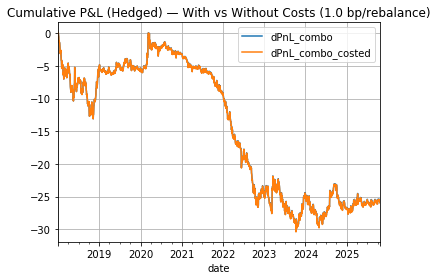

In [6]:
# Simple cost model: each time ratios change, pay cost = cost_bps * (|Δh_IEF|*P_IEF + |Δh_TLT|*P_TLT)
# cost per $100 notional; cost_bps = 1 bp => 0.0001 * price * |Δh|
cost_bps = 1.0

bt_cost = bt.copy()
bt_cost["cost"] = 0.0
prices = bt_cost[["IEF","TLT"]]
dh = bt_cost[["h_IEF","h_TLT"]].diff().abs().fillna(0.0)
bt_cost["cost"] = (cost_bps/10000.0) * (dh["h_IEF"]*prices["IEF"] + dh["h_TLT"]*prices["TLT"])
bt_cost["dPnL_combo_costed"] = bt_cost["dPnL_combo"] - bt_cost["cost"]

summary_bt_cost = pd.Series({
    "AnnVol_hedged_costed": ann_vol(bt_cost["dPnL_combo_costed"]),
    "VarianceReduction_%_costed": var_reduction(bt["dPnL_port"], bt_cost["dPnL_combo_costed"]),
    "MaxDD_hedged_costed": max_drawdown(bt_cost["dPnL_combo_costed"]),
    "VaR95_hedged_costed": hist_var(bt_cost["dPnL_combo_costed"], 0.95),
}).to_frame("Backtest_with_costs")

summary_bt_cost.round(4).to_csv(os.path.join(DATA, "backtest_summary_with_costs.csv"))
print(summary_bt_cost.round(4))

plt.figure(figsize=(10,4))
bt_cost[["dPnL_combo","dPnL_combo_costed"]].cumsum().plot()
plt.title(f"Cumulative P&L (Hedged) — With vs Without Costs ({cost_bps} bp/rebalance)"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(FIGS, "bt_cum_pnl_costs.png"), dpi=150); plt.show()


In [7]:
overall = summary_bt["Backtest_Overall"].round(4).to_dict()
p50_par = tbl_par.loc["P50"].round(3).to_dict()
p50_ls  = tbl_ls.loc["P50"].round(3).to_dict()

md = f"""# Step 7 — Analysis Summary

## Historical Backtest (2018 → latest)
- **Ann. Vol (Unhedged → Hedged):** {overall['AnnVol_unhedged']} → {overall['AnnVol_hedged']}
- **Variance Reduction:** {overall['VarianceReduction_%']}%
- **Max Drawdown (Unhedged → Hedged):** {overall['MaxDD_unhedged']} → {overall['MaxDD_hedged']}
- **VaR95 (Unhedged → Hedged):** {overall['VaR95_unhedged']} → {overall['VaR95_hedged']}
- **Sharpe-like (Unhedged → Hedged):** {overall['Sharpe_like_unhedged']} → {overall['Sharpe_like_hedged']}

See CSVs:
- `data/backtest_summary_overall.csv`
- `data/backtest_summary_by_year.csv`

Key figures saved under `figs/`:
- `bt_cum_pnl.png`, `bt_rolling_vol.png`, `bt_pnl_hist.png`, `bt_hedge_ratios.png`, `bt_turnover_hist.png`

## Simulation (1y horizon, 500 paths)
**Parallel model (median path):**
- Ann. Vol (Unhedged → Hedged): {p50_par['AnnVol_unhedged']} → {p50_par['AnnVol_hedged']}
- Variance Reduction: {p50_par['VarReduction_%']}%
- Max DD (Unhedged → Hedged): {p50_par['MaxDD_unhedged']} → {p50_par['MaxDD_hedged']}
- VaR95 (Unhedged → Hedged): {p50_par['VaR95_unhedged']} → {p50_par['VaR95_hedged']}

**Level+Slope model (median path):**
- Ann. Vol (Unhedged → Hedged): {p50_ls['AnnVol_unhedged']} → {p50_ls['AnnVol_hedged']}
- Variance Reduction: {p50_ls['VarReduction_%']}%
- Max DD (Unhedged → Hedged): {p50_ls['MaxDD_unhedged']} → {p50_ls['MaxDD_hedged']}
- VaR95 (Unhedged → Hedged): {p50_ls['VaR95_unhedged']} → {p50_ls['VaR95_hedged']}

Percentile tables saved under:
- `data/sim_summary_parallel_percentiles.csv`
- `data/sim_summary_level_slope_percentiles.csv`

## Caveats & Assumptions
- CMT treated as zeros; ETFs approximated via KRD splits; linear MTM for ETFs.
- Vasicek (Gaussian) dynamics; fat tails and basis risk understated.
- Monthly rebalances; transaction costs optional (see cost-aware variant).
"""

OUT_MD = os.path.join(BASE, "ANALYSIS_SUMMARY.md")
with open(OUT_MD, "w") as f:
    f.write(md)

print("Wrote:", OUT_MD)
print(md.splitlines()[0], "…")


Wrote: /Users/oltimyrtaj/Desktop/bonds_project/ANALYSIS_SUMMARY.md
# Step 7 — Analysis Summary …
